# Exploration

Before diving into the data, we clarify the purpose of this notebook.

This analysis focuses on understanding the structure, quality, and risk patterns of the Lending Club loan dataset, considering only information available at the time of loan application.

The goal is not to train models yet, but to:
- understand the dataset composition,
- validate assumptions,
- identify potential issues (e.g. imbalance, leakage, data quality),
- and generate hypotheses to guide feature engineering, modeling and decision making.

# Dataset Overview

We start with a high-level inspection of the dataset to answer the following questions:

- How many observations and variables are available?
- What are the data types of each variable?
- Is the dataset size compatible with the intended modeling approach?


In [1]:
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

sns.set_theme()
pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_parquet("../data/lending_club.parquet")

print(data.shape)
data.head()

(2925492, 141)


,loan_id,loan_amount_requested,loan_amount_funded,loan_amount_funded_investors,loan_term_months,interest_rate,monthly_payment,loan_grade,loan_subgrade,employment_title,employment_length_years,home_ownership_status,annual_income,income_verification_status,loan_issue_date,loan_status,payment_plan_flag,loan_listing_url,loan_purpose,loan_title,zip_code_first3,state,debt_to_income_ratio,delinquencies_past_2years,earliest_credit_line_date,fico_score_low,fico_score_high,inquiries_last_6months,months_since_last_delinquency,months_since_last_public_record,open_credit_lines,public_records_count,revolving_balance,revolving_utilization_rate,total_credit_lines,initial_listing_status,outstanding_principal,outstanding_principal_investors,total_payments_received,total_payments_received_investors,total_principal_received,total_interest_received,total_late_fees_received,recoveries_post_chargeoff,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,fico_score_high_last,fico_score_low_last,collections_12months_excluding_medical,months_since_major_derogatory,policy_code,application_type,annual_income_joint,debt_to_income_ratio_joint,verification_status_joint,accounts_currently_delinquent,total_collection_amount,total_current_balance,open_trades_last_6months,active_installment_trades,installment_accounts_opened_12m,installment_accounts_opened_24m,months_since_recent_installment,total_installment_balance,installment_utilization,revolving_trades_opened_12m,revolving_trades_opened_24m,max_balance_bankcard,all_util,total_rev_hi_lim,finance_inquiries,finance_trades_count,inquiries_last_12months,accounts_opened_past_24months,average_current_balance,bankcard_open_to_buy,bankcard_utilization,chargeoffs_within_12months,delinquent_amount,months_since_oldest_installment,months_since_oldest_revolving,months_since_recent_revolving,months_since_recent_account,mortgage_accounts_count,months_since_recent_bankcard,months_since_recent_bankcard_delinquency,months_since_recent_inquiry,months_since_recent_revolving_delinquency,accounts_ever_120days_past_due,active_bankcard_accounts,active_revolving_trades,satisfactory_bankcard_accounts,bankcard_accounts_count,installment_accounts_count,open_revolving_trades,revolving_accounts_count,revolving_trades_with_balance,satisfactory_accounts_count,accounts_120days_past_due,accounts_30days_past_due,accounts_90plus_days_past_due_24m,accounts_opened_past_12months,percent_trades_never_delinquent,percent_bankcard_over_75pct_limit,public_records_bankruptcies,tax_liens_count,total_high_credit_limit,total_balance_excluding_mortgage,total_bankcard_limit,total_installment_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,secondary_app_earliest_credit_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,secondary_app_active_installment_trades,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_plan_flag,hardship_plan_type,hardship_plan_reason,hardship_plan_status,hardship_deferral_months,hardship_plan_monthly_payment,hardship_plan_start_date,hardship_plan_end_date,hardship_payment_plan_start_date,hardship_plan_length_months,hardship_plan_days_past_due,hardship_plan_loan_status,hardship_projected_interest,hardship_payoff_balance,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,0.837,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,2015-01-01,171.62,NaT,2020-05-01,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N

# Target Eligibility and Censoring

Before assessing data quality or risk patterns, we define which loans are eligible to be included in the analysis.

As this project focuses on a granting model, the target must represent a final contract-level outcome: whether the loan was fully repaid or not within a defined observation window. We won't consider strategies related to collections, partial payments, or other intermediary outcomes — the emphasis is solely on the definitive final status of each loan for modeling grant risk.

In this section, we aim to:
- identify loans with a finalized outcome,
- exclude loans in transitory or ongoing states,
- and ensure that the target variable is well-defined and free from censoring issues.

Only loans whose repayment outcome is fully observed are retained for subsequent analysis.


To determine censored loans, ideally we need the timestamp when the dataset was generated. As we do not have this information, we will assume that the latest loan issue date available in the data is the effective censoring cutoff.

Not applying this approach (i.e., simply filtering out loans that are still in progress) can artificially lower observed default rates for more recent periods, since these loans haven't had enough time to reach their final status.

For loans with longer terms, this strategy may remove a substantial amount of data, which is not ideal. However, for simplicity, we will proceed with this method here. 

As an alternative — especially for longer-term loans — we could define censoring as a fixed observation window, such as 6 or 12 months after origination, or a certain percentage (e.g., 20%) of the loan term. If the loan remains current at that point, we could infer the likely remaining default rate based on historical data and factor this into model evaluation or future policy creation.

This would allow us to include a much larger sample while minimizing biases from including incomplete or recently originated loans.

A good idea here is to compare the average default rate in both scenarios to understand which approach makes more sense.

In [3]:
plot_raw_data = (
    data.assign(default_binary_raw=(data["loan_status"] != "Fully Paid").astype(int))
    .groupby("loan_issue_date", as_index=False)["default_binary_raw"]
    .mean()
)
plot_raw_data.columns = ["loan_issue_date", "Raw Default Rate"]

In [4]:
data["loan_maturity_date"] = data["loan_issue_date"] + pd.to_timedelta(
    data["loan_term_months"] * 30.4375, unit="D"
)
data["loan_censored"] = data["loan_maturity_date"] > data["loan_issue_date"].max()

In [5]:
status_counts = (
    data["loan_status"].astype("string").fillna("<<MISSING>>").value_counts(dropna=False).to_frame("count")
)

status_counts["percentage"] = status_counts["count"] / len(data)
status_counts["percentage"] = status_counts["percentage"].apply(lambda x: f"{x:.1%}")


# Adiciona contagem e percentual de censura por status
def censored_stats(s):
    mask = data["loan_status"].astype("string") == s
    return data.loc[mask, "loan_censored"].sum()


status_counts["censored_count"] = [censored_stats(idx) for idx in status_counts.index]
status_counts["censored_percentage"] = [
    (
        f"{(status_counts.loc[idx, 'censored_count'] / status_counts.loc[idx, 'count']):.1%}"
        if status_counts.loc[idx, "count"] > 0
        else "0.0%"
    )
    for idx in status_counts.index
]

print(f"Percent of censored loans: {data['loan_censored'].mean():.1%}")
print(f"Total of uncensored loans: {data['loan_censored'].count() - data['loan_censored'].sum()}")

data = data[~data["loan_censored"]]

status_counts

Percent of censored loans: 51.9%
Total of uncensored loans: 1406983


,count,percentage,censored_count,censored_percentage
loan_status,,,,
Fully Paid,1497783,51.2%,373095,24.9%
Current,1031016,35.2%,983909,95.4%
Charged Off,362548,12.4%,132635,36.6%
Late (31-120 days),16154,0.6%,14889,92.2%
In Grace Period,10028,0.3%,9186,91.6%
Late (16-30 days),2719,0.1%,2493,91.7%
Issued,2062,0.1%,2062,100.0%
Does not meet the credit policy. Status:Fully Paid,1988,0.1%,0,0.0%
Does not meet the credit policy. Status:Charged Off,761,0.0%,0,0.0%


In [6]:
# Define "eligible population" based on finalized outcomes
final_status_values = {"Fully Paid", "Charged Off"}
status_series = data["loan_status"].astype("string")

eligible_mask = status_series.isin(list(final_status_values))
ineligible_mask = ~eligible_mask

print("\nEligibility (final outcome observed):")
print(f"- Eligible: {eligible_mask.sum():,} ({eligible_mask.mean():.2%})")
print(f"- Ineligible: {ineligible_mask.sum():,} ({ineligible_mask.mean():.2%})")

# Show which ineligible statuses exist (if any)
if ineligible_mask.any():
    print("\nIneligible statuses present (should be removed for binary granting target):")
    display(status_series[ineligible_mask].value_counts().to_frame("count"))


Eligibility (final outcome observed):
- Eligible: 1,354,601 (96.28%)
- Ineligible: 52,382 (3.72%)

Ineligible statuses present (should be removed for binary granting target):


,count
loan_status,
Current,47107
Does not meet the credit policy. Status:Fully Paid,1988
Late (31-120 days),1265
In Grace Period,842
Does not meet the credit policy. Status:Charged Off,761
Late (16-30 days),226
Default,193


In [7]:
# Build the binary target on the eligible set (final outcome only)
target_map = {
    "Fully Paid": 0,
    "Charged Off": 1,
    # "Default": 1,
    # "Late": 1
}

data = data.loc[eligible_mask].copy()
data["default_binary"] = data["loan_status"].astype("string").map(target_map)

# Sanity check
print("\nTarget construction sanity checks (eligible subset only):")
display(data["default_binary"].value_counts(dropna=False))
print(f"Missing target after mapping: {data['default_binary'].isna().sum():,}")


Target construction sanity checks (eligible subset only):


default_binary
0    1124688
1     229913
Name: count, dtype: int64

Missing target after mapping: 0


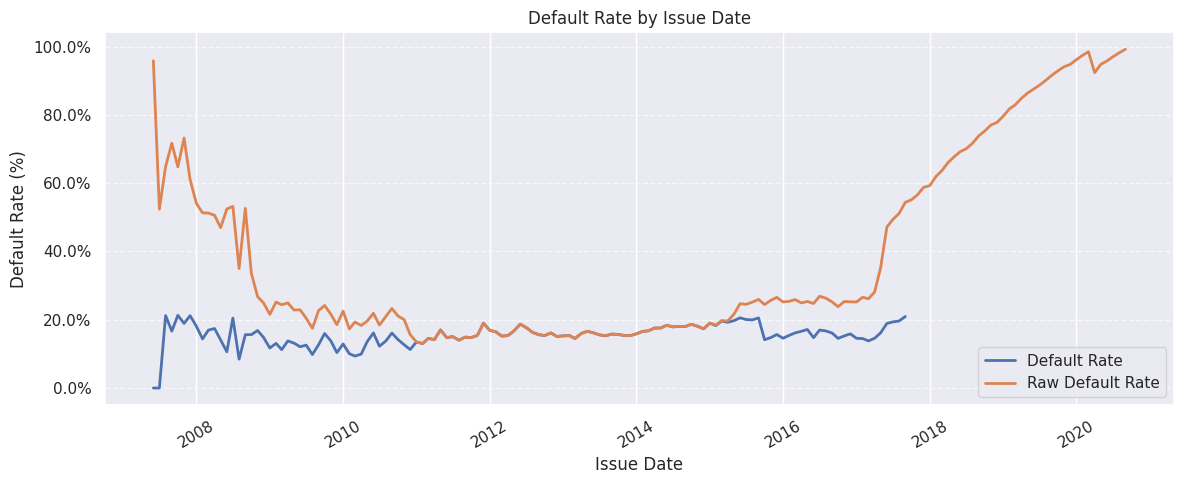

In [8]:
# Normal default rate: only for eligible (finalized) loans
plot_data = data.groupby("loan_issue_date", as_index=False)["default_binary"].mean()
plot_data.columns = ["loan_issue_date", "Default Rate"]

# Combine both series for comparison plot
combined_plot_df = pd.merge(plot_data, plot_raw_data, on="loan_issue_date", how="outer").sort_values(
    "loan_issue_date"
)

plt.figure(figsize=(12, 5))
sns.lineplot(data=combined_plot_df, x="loan_issue_date", y="Default Rate", label="Default Rate", linewidth=2)
sns.lineplot(
    data=combined_plot_df, x="loan_issue_date", y="Raw Default Rate", label="Raw Default Rate", linewidth=2
)

plt.title("Default Rate by Issue Date")
plt.xlabel("Issue Date")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.grid(True, which="both", axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The chart above illustrates the exact point made previously: without properly addressing censoring, the reported default rates can be misleading in certain periods. Continuing with the analysis without this treatment could result in conclusions that would be questionable in a real-world scenario.

Although this is not the ideal approach — since we lose a significant amount of data and there would be better ways to handle censoring if we had a more complete dataset with censoring information — it is still preferable to take this route rather than proceed without any correction for the biases that could otherwise result.

# Variable Roles and Data Availability

Since this is a credit granting dataset, it is critical to confirm that all explanatory variables are available ex-ante, at the moment of the loan request.

Here we should aim to:
- distinguish which variables are explanatory,
- and ensure no post-decision or post-outcome information is present.

But we already performed this step in the previous notebook: 00_data_acquisition.

Here, we will simply generate the list of variables that could be used as features for a model.

In [9]:
model_features = [
    # --- Applicant-Provided Information ---
    # Borrower Demographics & Employment
    "employment_title",
    "employment_length_years",
    "home_ownership_status",
    "annual_income",
    "annual_income_joint",
    "state",
    "zip_code_first3",
    "application_type",
    # Loan Request Characteristics
    "loan_amount_requested",
    "loan_purpose",
    "loan_title",
    # Income Verification
    "income_verification_status",
    # --- Credit Bureau Information ---
    # Credit Scores
    "fico_score_low",
    "fico_score_high",
    # Debt & Affordability Ratios
    "debt_to_income_ratio",
    "debt_to_income_ratio_joint",
    # Credit History - Delinquency & Defaults
    "delinquencies_past_2years",
    "months_since_last_delinquency",
    "accounts_currently_delinquent",
    "delinquent_amount",
    "months_since_major_derogatory",
    "accounts_30days_past_due",
    "accounts_120days_past_due",
    "accounts_90plus_days_past_due_24m",
    "accounts_ever_120days_past_due",
    "public_records_count",
    "public_records_bankruptcies",
    "tax_liens_count",
    # Credit History - Credit Lines & Accounts
    "earliest_credit_line_date",
    "open_credit_lines",
    "total_credit_lines",
    "months_since_last_public_record",
    # Revolving Credit
    "revolving_balance",
    "revolving_utilization_rate",
    "revolving_trades_opened_12m",
    "revolving_trades_opened_24m",
    "revolving_accounts_count",
    "revolving_trades_with_balance",
    "open_revolving_trades",
    "active_revolving_trades",
    "months_since_oldest_revolving",
    "months_since_recent_revolving",
    "months_since_recent_revolving_delinquency",
    # Installment Accounts
    "active_installment_trades",
    "installment_accounts_opened_12m",
    "installment_accounts_opened_24m",
    "installment_accounts_count",
    "total_installment_balance",
    "installment_utilization",
    "months_since_recent_installment",
    "months_since_oldest_installment",
    "total_installment_credit_limit",
    # Bankcard Accounts
    "bankcard_accounts_count",
    "active_bankcard_accounts",
    "satisfactory_bankcard_accounts",
    "bankcard_utilization",
    "bankcard_open_to_buy",
    "max_balance_bankcard",
    "months_since_recent_bankcard",
    "months_since_recent_bankcard_delinquency",
    "percent_bankcard_over_75pct_limit",
    # Credit Inquiries & Recent Activity
    "inquiries_last_6months",
    "inquiries_last_12months",
    "finance_inquiries",
    "months_since_recent_inquiry",
    "open_trades_last_6months",
    "accounts_opened_past_12months",
    "accounts_opened_past_24months",
    # Account Balances & Limits
    "total_current_balance",
    "total_high_credit_limit",
    "total_balance_excluding_mortgage",
    "total_bankcard_limit",
    "average_current_balance",
    # Additional Account Metrics
    "satisfactory_accounts_count",
    "finance_trades_count",
    "months_since_recent_account",
    "mortgage_accounts_count",
    "percent_trades_never_delinquent",
    # Secondary Applicant (Joint Applications)
    "secondary_app_earliest_credit_line",
    "secondary_app_active_installment_trades",
]

# Data Quality Assessment

Before analyzing risk patterns, we assess the overall quality of the data.

Key questions explored in this section:
- Are there missing values? If so, how frequent are they?
- Are missing values concentrated in specific variables or segments?
- Are there duplicated records or obvious inconsistencies?


In [10]:
len(list(model_features))

80

In [11]:
missing_counts = data[model_features].isna().sum()
missing_percent = data[model_features].isna().mean() * 100
missing_table = pd.DataFrame(
    {"missing_count": missing_counts, "missing_percent": missing_percent}
).sort_values(by="missing_count", ascending=False)
missing_table.head(30)

,missing_count,missing_percent
secondary_app_earliest_credit_line,1345907,99.358187
secondary_app_active_installment_trades,1345907,99.358187
debt_to_income_ratio_joint,1338413,98.804962
annual_income_joint,1338410,98.804740
months_since_last_public_record,1126356,83.150389
months_since_recent_bankcard_delinquency,1028229,75.906411
months_since_major_derogatory,996198,73.541803
installment_utilization,893763,65.979798
months_since_recent_revolving_delinquency,893564,65.965107
months_since_recent_installment,835121,61.650700


In [12]:
null_percentage = missing_table["missing_percent"].values

deciles = list(range(0, 101, 10))
features_above_decile = []
for decile in deciles:
    count = (null_percentage > decile).sum()
    features_above_decile.append(count)

tabela_decis = pd.DataFrame(
    {"decile (%)": deciles, "n_features_above_decile": features_above_decile}
).set_index("decile (%)")
tabela_decis.T

decile (%),0,10,20,30,40,50,60,70,80,90,100
n_features_above_decile,62,23,22,22,22,21,21,7,5,4,0


Of our initial 81 variables, more than 20 have over 60% missing values. For some of these, we can try to understand how the proportion of missing values changes over time.

['secondary_app_earliest_credit_line', 'secondary_app_active_installment_trades', 'debt_to_income_ratio_joint', 'annual_income_joint', 'months_since_last_public_record', 'months_since_recent_bankcard_delinquency', 'months_since_major_derogatory', 'installment_utilization', 'months_since_recent_revolving_delinquency', 'months_since_recent_installment', 'active_installment_trades', 'revolving_trades_opened_12m', 'installment_accounts_opened_24m', 'inquiries_last_12months', 'finance_inquiries', 'total_installment_balance', 'max_balance_bankcard', 'finance_trades_count', 'open_trades_last_6months', 'installment_accounts_opened_12m', 'revolving_trades_opened_24m', 'months_since_last_delinquency']


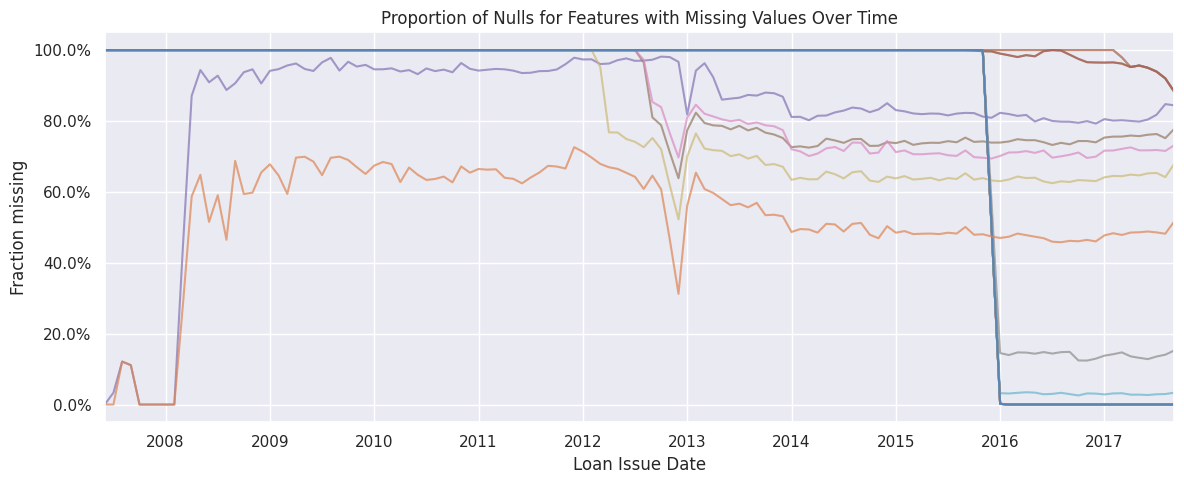

In [13]:
has_null_features = missing_table[missing_table["missing_percent"] > 30].index.tolist()
print(has_null_features)

nulls_over_time = data[has_null_features].isna().groupby(data["loan_issue_date"]).mean()

plt.figure(figsize=(12, 5))
nulls_over_time.plot(ax=plt.gca(), legend=False, alpha=0.7)
plt.title("Proportion of Nulls for Features with Missing Values Over Time")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.ylabel("Fraction missing")
plt.xlabel("Loan Issue Date")
plt.tight_layout()
plt.show()

Many of the features with missing data have long periods where no values are present at all. Even when these features start to appear, they still tend to have a high proportion of missing values. In this case, it does not seem like missingness itself is informative. Some features do become completely filled after a certain point in time, but they only cover a very small portion of the dataset. For these reasons, I will proceed without including any of these features with high missingness.

In [14]:
model_features = [feature for feature in model_features if feature not in has_null_features]

In [15]:
data[model_features].duplicated().sum()

np.int64(0)

In [16]:
numerical_columns = data[model_features].select_dtypes(include=["number"]).columns
data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,1354601.0,75478.994147,85986.099954,0.0,45000.000,64000.00,90000.000,6.100000e+07
loan_amount_requested,1354601.0,13739.202097,8546.176584,500.0,7000.000,12000.00,19200.000,4.000000e+04
fico_score_low,1354601.0,695.474442,31.378607,625.0,670.000,690.00,710.000,8.450000e+02
fico_score_high,1354601.0,699.474568,31.379207,629.0,674.000,694.00,714.000,8.500000e+02
debt_to_income_ratio,1354422.0,18.192026,9.807916,-1.0,11.830,17.61,24.010,9.990000e+02
delinquencies_past_2years,1354601.0,0.330849,0.898812,0.0,0.000,0.00,0.000,4.200000e+01
accounts_currently_delinquent,1354601.0,0.005526,0.080635,0.0,0.000,0.00,0.000,1.400000e+01
delinquent_amount,1354601.0,15.598629,825.424754,0.0,0.000,0.00,0.000,2.499250e+05
accounts_30days_past_due,1287074.0,0.003781,0.065421,0.0,0.000,0.00,0.000,4.000000e+00
accounts_120days_past_due,1239140.0,0.000886,0.031672,0.0,0.000,0.00,0.000,6.000000e+00


The only inconsistency that stands out to me is the minimum value of debt_to_income_ratio being negative. Since there is only one row with this value, we will remove it and move forward.

In [17]:
display(data[["debt_to_income_ratio"]].query("debt_to_income_ratio < 0"))
data = data.drop(data[data["debt_to_income_ratio"] < 0].index).reset_index(drop=True)

,debt_to_income_ratio
2320120,-1.0


# Target Variable Analysis

The target variable represents the **final status of the loan** (fully paid vs default).

In this section, we explore:
- the overall default rate,
- whether the dataset is highly imbalanced,
- and whether the observed default rate is consistent with expectations for unsecured personal loans.


We have already examined part of this earlier, but here I will present a clean chart and the expected average default rate. I will also try to analyze how default probability varies with the number of installments, for example.

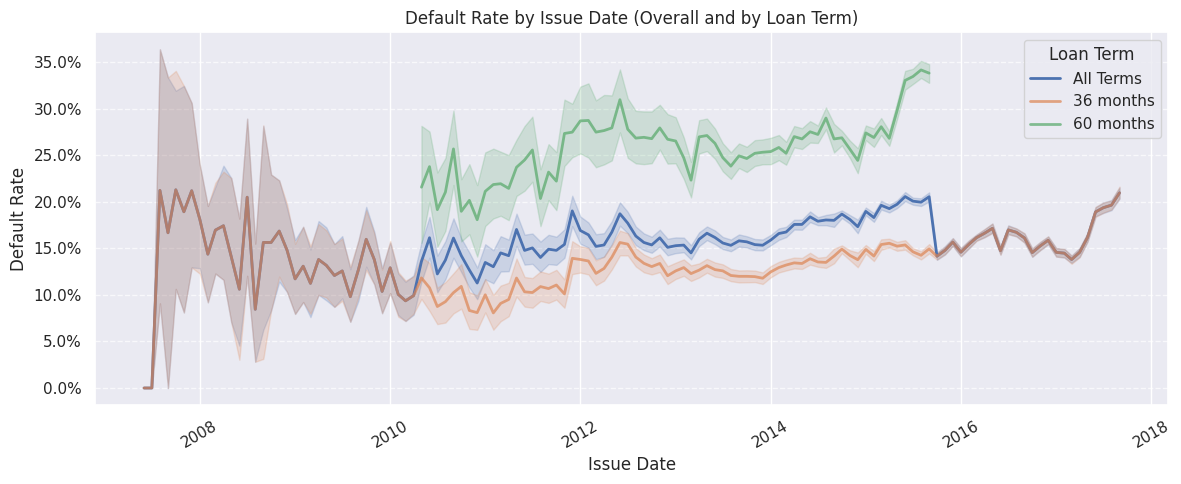

In [18]:
plt.figure(figsize=(12, 5))

# Plot overall default rate by issue date
sns.lineplot(data=data, x="loan_issue_date", y="default_binary", linewidth=2, label="All Terms")

# Plot for each loan_term_months separately
for term, df_term in data.groupby("loan_term_months"):
    sns.lineplot(
        data=df_term,
        x="loan_issue_date",
        y="default_binary",
        linewidth=2,
        label=f"{int(term)} months",
        alpha=0.7,
    )

plt.title("Default Rate by Issue Date (Overall and by Loan Term)")
plt.xlabel("Issue Date")
plt.ylabel("Default Rate")
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.legend(title="Loan Term")
plt.grid(True, which="both", axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
data.groupby("loan_term_months").size()

loan_term_months
36    1139691
60     214909
dtype: int64

This explains the drop in the average risk in 2016: our censoring was excluding loans from this period with 60 monthly installments, which have a significantly higher risk than loans with 36 installments. Even so, it appears the censoring has not yet adequately addressed the most recent data.

To keep things simple, we will work only with loans that have 36 monthly installments. In the future, a policy could extend the results obtained for this product to the longer-term product as well. Furthermore, since we previously applied hypothesis-driven censoring, we will further trim the most recent data to ensure that the observed default rate is consistent with the rest of the dataset, assuming that this pattern is not the result of any specific company policy.

In [20]:
data.groupby("loan_issue_date")["default_binary"].mean().tail(10)

loan_issue_date
2016-12-01    0.158575
2017-01-01    0.145629
2017-02-01    0.144777
2017-03-01    0.137959
2017-04-01    0.145685
2017-05-01    0.161636
2017-06-01    0.189025
2017-07-01    0.193585
2017-08-01    0.196295
2017-09-01    0.209503
Name: default_binary, dtype: float64

In [21]:
data = data[data["loan_term_months"] == 36]
data = data[data["loan_issue_date"] < pd.to_datetime("2017-06-01")]

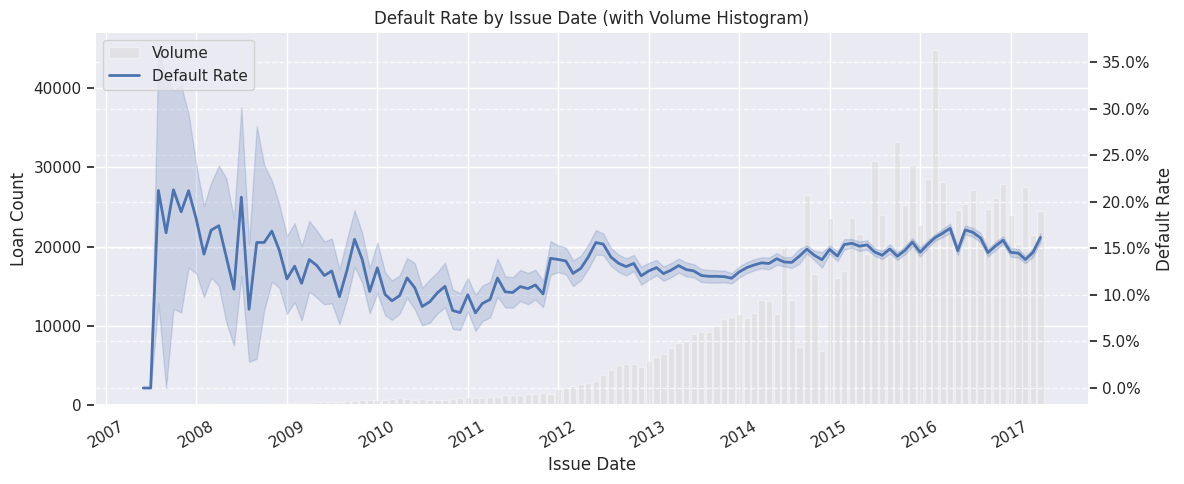

In [22]:
plt.figure(figsize=(12, 5))
ax1 = plt.gca()

counts_by_date = data.groupby("loan_issue_date").size()
ax1.bar(
    counts_by_date.index,
    counts_by_date.values,
    width=25,
    color="lightgrey",
    alpha=0.4,
    label="Volume",
    zorder=1,
)

ax2 = ax1.twinx()
sns.lineplot(
    data=data,
    x="loan_issue_date",
    y="default_binary",
    linewidth=2,
    ax=ax2,
    color="C0",
    label="Default Rate",
    zorder=2,
)

ax2.set_ylabel("Default Rate")
ax2.yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
ax1.set_ylabel("Loan Count")
ax1.set_xlabel("Issue Date")
plt.title("Default Rate by Issue Date (with Volume Histogram)")

for label in ax1.get_xticklabels():
    label.set_rotation(30)

ax2.grid(True, which="both", axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc="upper left", title=None)
plt.show()

# Numerical Variables: Univariate Analysis

We now explore the distribution of key numerical variables.

The objectives are to:
- understand their scale and dispersion,
- identify skewness or heavy tails,
- and detect potential outliers that may require transformation or capping.


We have already taken a preliminary look at the distribution of numerical variables, but now we will explore them in more depth.

In [23]:
numerical_features = [feature for feature in model_features if feature in numerical_columns]

numeric_summary = (
    data[numerical_features]
    .describe(percentiles=[0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99])
    .T.rename(
        columns={
            "1%": "p01",
            "10%": "p10",
            "25%": "p25",
            "50%": "p50",
            "75%": "p75",
            "90%": "p90",
            "99%": "p99",
        }
    )[["count", "mean", "std", "min", "p01", "p10", "p25", "p50", "p75", "p90", "p99", "max"]]
)

numeric_summary

,count,mean,std,min,p01,p10,p25,p50,p75,p90,p99,max
annual_income,1059906.0,74535.434047,91857.048426,0.0,17000.000,32000.000,44000.000,62000.000,90000.000,125000.000,260000.000,6.100000e+07
loan_amount_requested,1059906.0,12594.098463,8162.746628,500.0,1500.000,4000.000,6400.000,10000.000,16450.000,25000.000,35000.000,4.000000e+04
fico_score_low,1059906.0,695.337454,31.558760,625.0,660.000,665.000,670.000,690.000,710.000,740.000,800.000,8.450000e+02
fico_score_high,1059906.0,699.337587,31.559393,629.0,664.000,669.000,674.000,694.000,714.000,744.000,804.000,8.500000e+02
debt_to_income_ratio,1059822.0,17.962847,9.554540,0.0,1.900,7.140,11.580,17.360,23.800,29.470,37.760,9.990000e+02
delinquencies_past_2years,1059906.0,0.334357,0.904838,0.0,0.000,0.000,0.000,0.000,0.000,1.000,4.000,3.000000e+01
accounts_currently_delinquent,1059906.0,0.005595,0.081481,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.400000e+01
delinquent_amount,1059906.0,16.367774,830.888983,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.854080e+05
accounts_30days_past_due,1008260.0,0.003820,0.065890,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000000e+00
accounts_120days_past_due,967606.0,0.000919,0.032279,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.000000e+00


There is a significant difference in the scale of several variables. If we plan to use models that are sensitive to feature scaling, it will be important to standardize or normalize these variables.

# Categorical Variables: Univariate Analysis

For categorical variables, we focus on structure rather than prediction.

Key questions include:
- How many categories does each variable have?
- Are some categories extremely rare?
- Are there dominant categories that may drive most observations?


Assessing coverage and cardinality of categorical fields helps identify sparse values and dominant modes that may need regrouping.

In [24]:
categorical_features = [feature for feature in model_features if feature not in numerical_features]

cat_profile = []
for col in categorical_features:
    series = data[col]
    value_counts = series.value_counts(dropna=True)
    top_category = value_counts.index[0] if not value_counts.empty else None
    top_pct = (value_counts.iloc[0] / len(series)) if not value_counts.empty else 0
    cat_profile.append(
        {
            "feature": col,
            "n_unique": series.nunique(dropna=True),
            "missing_pct": series.isna().mean() * 100,
            "top_category": str(top_category) if top_category is not None else None,
            "top_category_pct": top_pct * 100,
        }
    )

pd.DataFrame(cat_profile).sort_values(by="missing_pct", ascending=False)

,feature,n_unique,missing_pct,top_category,top_category_pct
0,employment_title,311221,7.011282,Teacher,1.643542
1,employment_length_years,11,6.480197,10+ years,31.678470
7,loan_title,50172,1.512870,Debt consolidation,47.450340
4,zip_code_first3,932,0.000094,112xx,1.124439
3,state,51,0.000000,CA,14.763573
2,home_ownership_status,6,0.000000,MORTGAGE,46.260612
5,application_type,2,0.000000,Individual,99.041802
6,loan_purpose,14,0.000000,debt_consolidation,55.865898
8,income_verification_status,3,0.000000,Source Verified,38.509547
9,earliest_credit_line_date,714,0.000000,2001-08-01 00:00:00,0.680532


We will exclude the variable 'application_type' from the analysis, since it has only two categories and the most frequent value accounts for 99% of cases. We will also disregard 'zip_code_first3' to maintain simplicity, as the 'state' variable already captures some geographic information. Additionally, this summary highlights several features that will require further processing, such as 'employment_title', 'loan_title' and 'earliest_credit_line_date'.

In [25]:
feature_to_exclude = ["application_type", "zip_code_first3"]
model_features = [feature for feature in model_features if feature not in feature_to_exclude]

# Relationship Between Explanatory Variables and Default

To generate modeling hypotheses, we analyze how default rates vary across different feature values.

This section explores:
- how default rates change across numerical feature ranges,
- how default rates differ between categories,
- and whether observed patterns are economically and intuitively reasonable.


Here, we will explore how certain numerical and categorical variables are related to default rates.

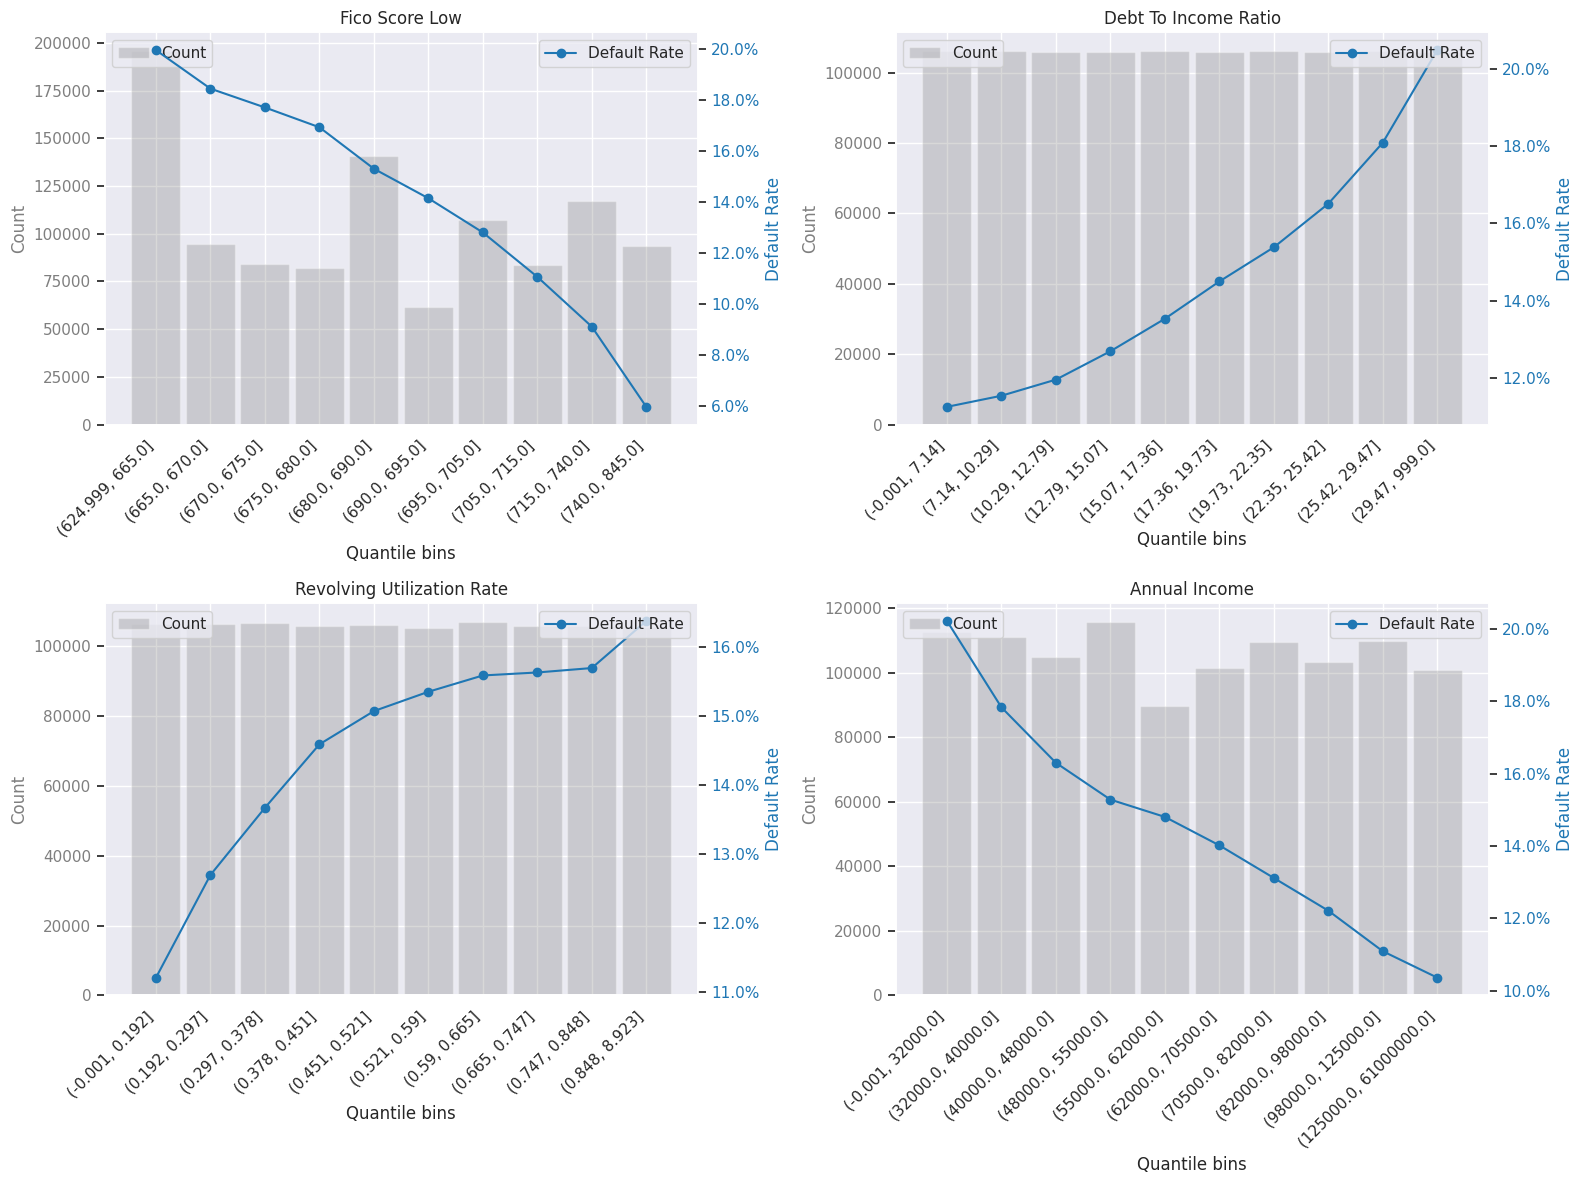

In [26]:
def default_rate_count_line(df, feature, q=10, ax=None):
    result = (
        df[[feature, "default_binary"]]
        .dropna()
        .assign(bin=lambda d: pd.qcut(d[feature], q=q, duplicates="drop"))
        .groupby("bin", observed=False)
        .agg(default_rate=("default_binary", "mean"), count=("default_binary", "size"))
        .reset_index()
        .assign(bin_label=lambda d: d["bin"].astype(str))
    )

    if ax is None:
        ax = plt.gca()

    color_hist = "tab:gray"
    color_line = "tab:blue"
    ax.bar(result["bin_label"], result["count"], color=color_hist, alpha=0.3, width=0.9, label="Count")
    ax.set_ylabel("Count", color=color_hist)
    ax.set_xlabel("Quantile bins")
    ax.set_title(feature.replace("_", " ").title())
    ax.tick_params(axis="y", labelcolor=color_hist)

    ax2 = ax.twinx()
    ax2.plot(result["bin_label"], result["default_rate"], marker="o", color=color_line, label="Default Rate")
    ax2.set_ylabel("Default Rate", color=color_line)
    ax2.tick_params(axis="y", labelcolor=color_line)
    ax2.yaxis.set_major_formatter(lambda x, _: f"{x*100:.1f}%")
    ax.set_xticks(range(len(result["bin_label"])))
    ax.set_xticklabels(result["bin_label"], rotation=45, ha="right")

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax2.grid(False)

    return ax, ax2


numerical_for_default = [
    "fico_score_low",
    "debt_to_income_ratio",
    "revolving_utilization_rate",
    "annual_income",
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, col in zip(axes.flat, numerical_for_default):
    default_rate_count_line(data, col, q=10, ax=ax)

plt.tight_layout()
plt.show()

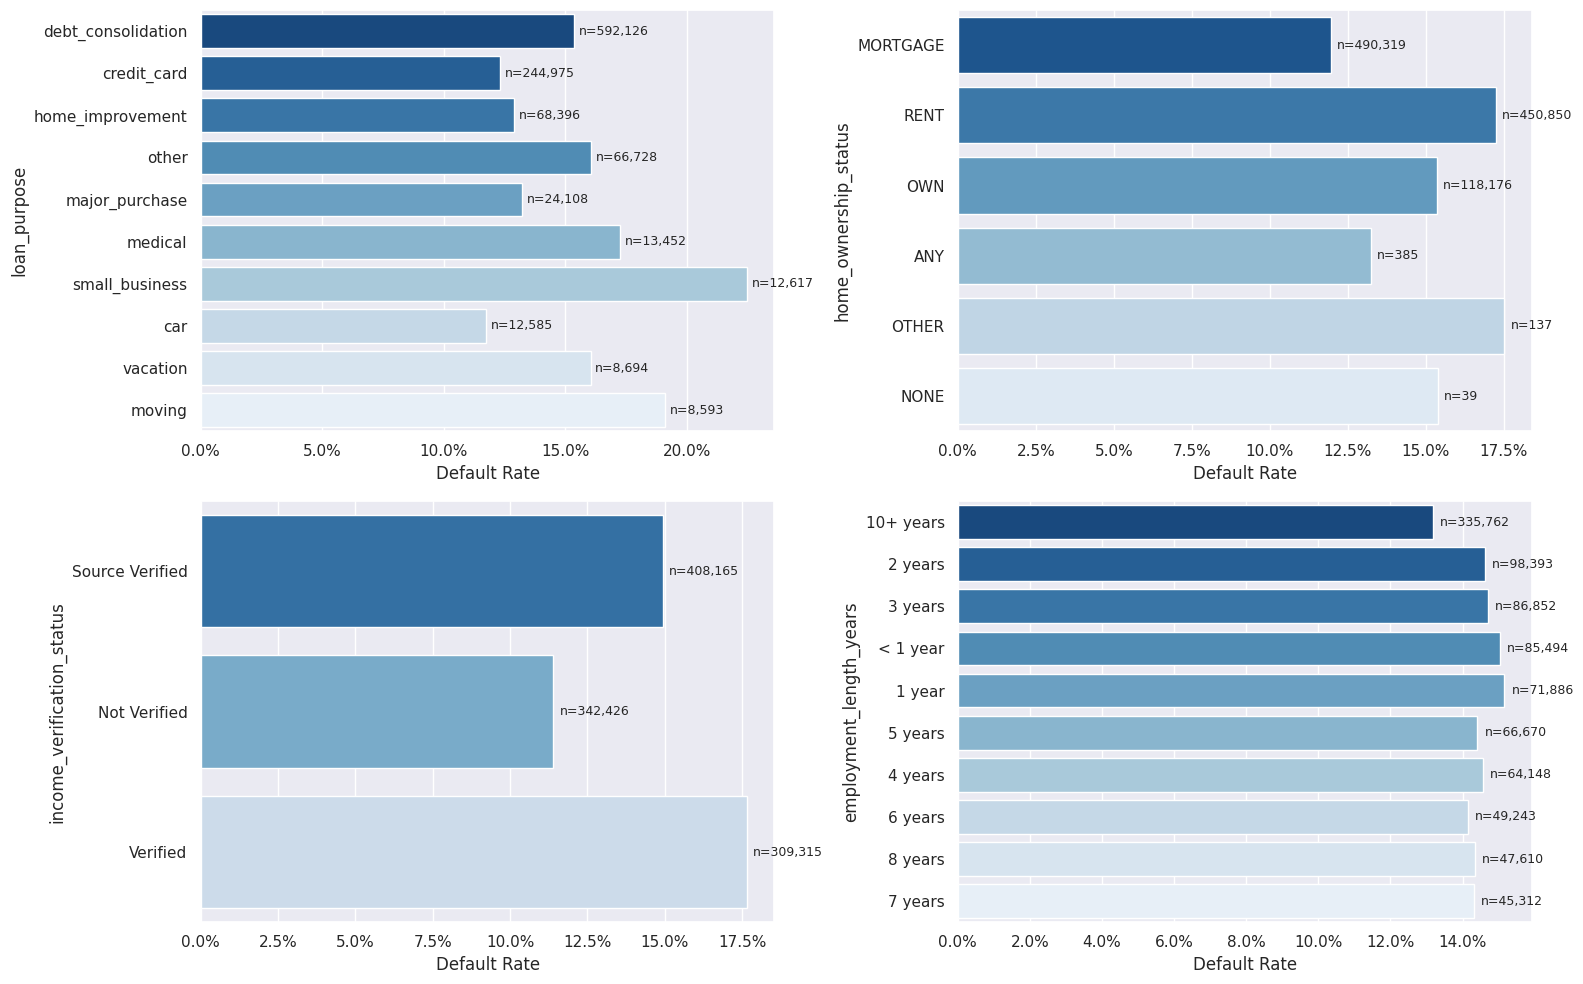

In [27]:
categorical_for_default = [
    "loan_purpose",
    "home_ownership_status",
    "income_verification_status",
    "employment_length_years",
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, col in zip(axes.flat, categorical_for_default):
    grouped = (
        data.groupby(col, observed=False)["default_binary"]
        .agg(default_rate="mean", count="size")
        .sort_values("count", ascending=False)
        .head(10)
        .reset_index()
    )

    sns.barplot(data=grouped, y=col, x="default_rate", hue=col, legend=False, ax=ax, palette="Blues_r")
    ax.set_xlabel("Default Rate")
    ax.xaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
    for i, cnt in enumerate(grouped["count"]):
        ax.text(grouped["default_rate"].iloc[i] + 0.002, i, f"n={cnt:,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# Textual Variables: Initial Inspection

The dataset includes borrower-provided text fields describing the loan request.

At this stage, we aim to:
- understand the completeness of textual information,
- inspect typical examples of cleaned text,
- and assess whether these variables may contain useful risk-related signals.


Quick checks on free-text completeness and length provide a sanity check before investing in NLP features.

In [28]:
text_columns = ["loan_title", "employment_title"]

text_profile = []
for col in text_columns:
    lengths = data[col].dropna().astype(str).str.len()
    text_profile.append(
        {
            "feature": col,
            "missing_pct": data[col].isna().mean() * 100,
            "median_length": lengths.median(),
            "p95_length": lengths.quantile(0.95),
        }
    )

pd.DataFrame(text_profile)

,feature,missing_pct,median_length,p95_length
0,loan_title,1.512870,18.0,23.0
1,employment_title,7.011282,15.0,30.0


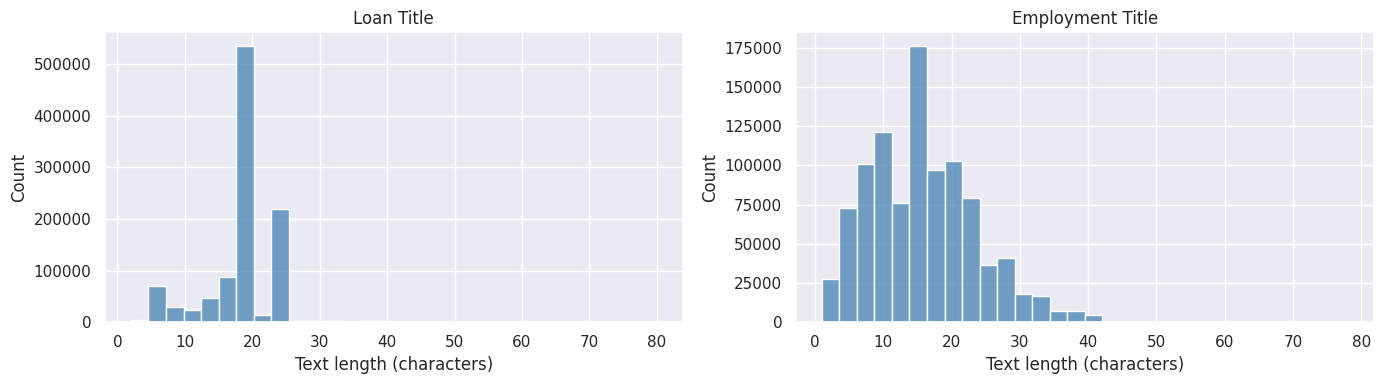

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, col in zip(axes, text_columns):
    lengths = data[col].dropna().astype(str).str.len()
    sns.histplot(lengths, bins=30, ax=ax, color="steelblue")
    ax.set_title(col.replace("_", " ").title())
    ax.set_xlabel("Text length (characters)")
plt.tight_layout()
plt.show()

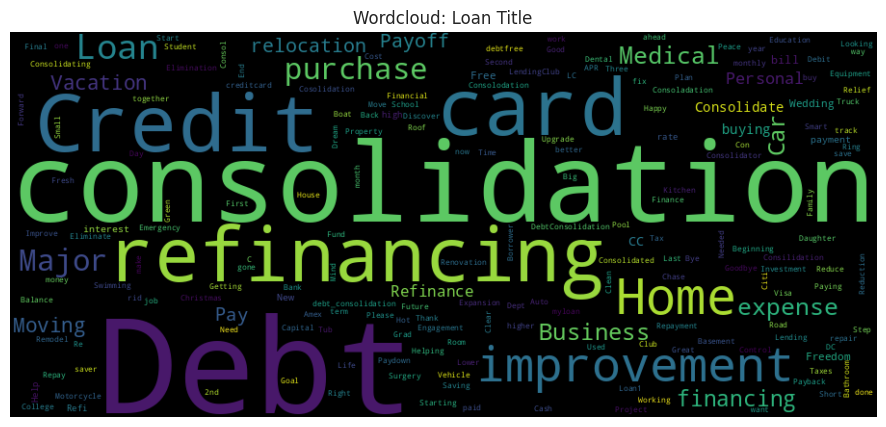

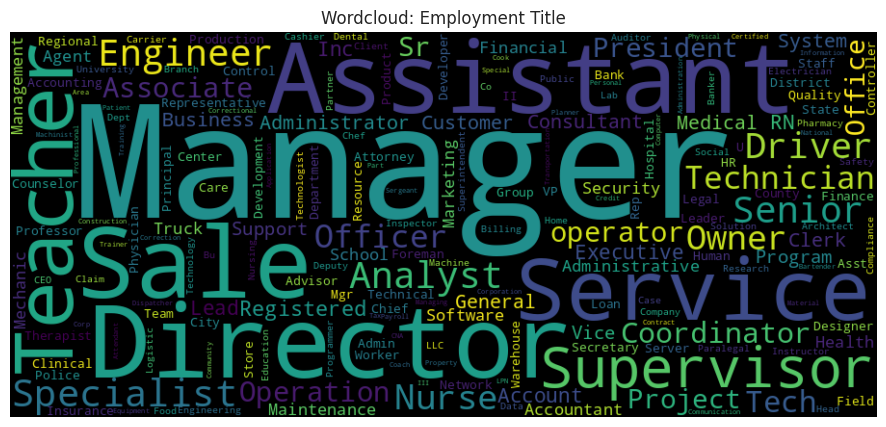

In [30]:
for col in text_columns:
    plt.figure(figsize=(14, 5))
    texts = data[col].dropna().astype(str).values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False, width=900, height=400
    ).generate(" ".join(texts))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Wordcloud: {col.replace("_", " ").title()}')
    plt.show()

In [31]:
data[text_columns + ["default_binary"]].dropna(subset=text_columns).sample(5, random_state=34)

,loan_title,employment_title,default_binary
482564,Debt consolidation,Database Adminisrator,1
1331182,Debt consolidation,Branch manager,0
1252809,Debt consolidation,IT Business Administrator,0
547359,Credit card refinancing,GM,0
599453,Debt consolidation,Teacher,0


# Correlation and Redundancy Analysis

Highly correlated variables may introduce redundancy and instability in some models.

Here we examine:
- correlations among numerical variables,
- potential multicollinearity,
- and opportunities for feature reduction or consolidation.


We inspect Kendall correlations on a sample to flag redundant numerical features that could be consolidated before modeling.

In [32]:
corr_sample = data[numerical_columns].dropna()
sample_size = 100_000
if len(corr_sample) > sample_size:
    corr_sample = corr_sample.sample(n=sample_size, random_state=34)

corr_matrix = corr_sample.corr(method="kendall")

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_corr_pairs = (
    upper.stack()
    .abs()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
)

top_corr_pairs.head(10)

,feature_1,feature_2,abs_corr
0,fico_score_low,fico_score_high,1.000000
1,open_credit_lines,satisfactory_accounts_count,0.995495
2,revolving_trades_with_balance,active_revolving_trades,0.995254
3,total_current_balance,total_high_credit_limit,0.870700
4,accounts_currently_delinquent,accounts_30days_past_due,0.790099
5,public_records_count,public_records_bankruptcies,0.788025
6,total_current_balance,average_current_balance,0.762501
7,active_bankcard_accounts,satisfactory_bankcard_accounts,0.754081
8,accounts_currently_delinquent,delinquent_amount,0.736791
9,delinquent_amount,accounts_30days_past_due,0.706478


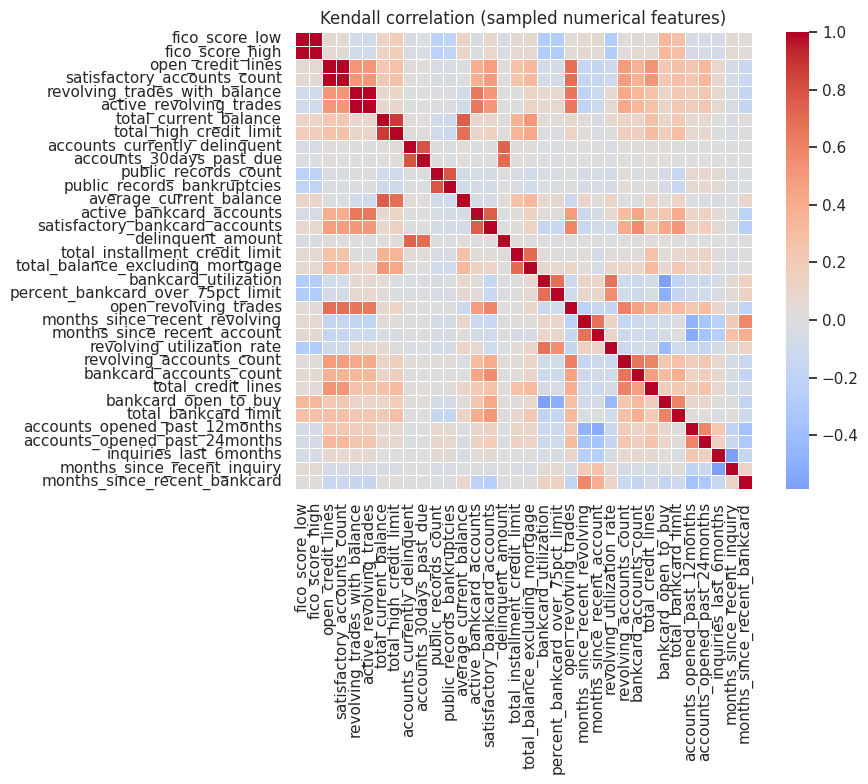

In [33]:
top_features = pd.unique(top_corr_pairs.head(30)[["feature_1", "feature_2"]].values.ravel())

if len(top_features) > 0:
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix.loc[top_features, top_features],
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
    )
    plt.title("Kendall correlation (sampled numerical features)")
    plt.tight_layout()
    plt.show()

In [34]:
data.to_parquet("../data/lending_club_exploration.parquet")
with open("../data/model_features.json", "w") as f:
    json.dump(list(model_features), f, indent=2)

# Key Insights and Next Steps

We conclude this exploratory analysis by summarizing:

- the main characteristics of the dataset,
- early signals associated with higher or lower default risk,
- data limitations and modeling risks identified during exploration,
- and how these findings will inform feature engineering and baseline modeling in subsequent notebooks.


**Key takeaways so far**

- After censoring and limiting to 36-month loans issued before mid-2017, the analysis set holds ~1.06M loans with a 14.6% default rate (moderate imbalance).
- Loan sizes are centered near $10k (p50) with a long tail to $25k at p90; incomes cluster around $62k (p50) and up to $125k at p90, suggesting simple log-scaling can stabilize these inputs.
- Risk is strongly monotonic for core drivers: default climbs from ~6% at the top FICO decile to ~20% at the bottom, and from ~11% to ~20% across DTI and utilization deciles; lower income bands also carry higher risk.
- Categorical splits show concentration and risk variation: `small_business` purpose (~22% default) and `medical` (~17%) outrank debt consolidation in risk, while `RENT` borrowers default ~5 p.p. more than `MORTGAGE`; verified income behaves as expected with higher observed risk where verification flags exist.
- Text fields are mostly populated (loan_title ~1.5% missing, employment_title ~7% missing) with short median lengths, so lightweight text cleaning (lowercasing, stopword removal) should suffice before embedding.
- Several numerical pairs are highly correlated (e.g., fico_score_low/high, revolving/account balance aggregates, utilization metrics), signaling opportunities for feature pruning or combining to reduce redundancy and multicollinearity.

With these insights, we are now well-prepared to proceed to the next stage: systematic preprocessing and feature engineering before moving into modeling.